In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from deeplearing_model import evaluate_regression_model,ModelSaver,EarlyStopping,plot_learning_curves,plot_learning_loss_curves
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# 准备数据

In [3]:
# 加载加利福尼亚房价数据集
housing = fetch_california_housing()
X = housing.data
y = housing.target

# 数据拆分：训练集(64%)、验证集(16%)、测试集(20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)  # 0.25 x 0.8 = 0.2

print(f"训练集大小: {X_train.shape[0]}")
print(f"验证集大小: {X_val.shape[0]}")
print(f"测试集大小: {X_test.shape[0]}")

训练集大小: 13209
验证集大小: 3303
测试集大小: 4128


In [4]:
# 数据标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# 自定义数据集类
class HousingDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.FloatTensor(features)
        self.targets = torch.FloatTensor(targets).view(-1, 1)
        
    def __len__(self):
        return len(self.features) #返回样本数量
    
    def __getitem__(self, idx): #传入索引，返回对应索引样本的特征和目标
        return self.features[idx], self.targets[idx]

# 创建数据集实例
train_dataset = HousingDataset(X_train_scaled, y_train)
val_dataset = HousingDataset(X_val_scaled, y_val)
test_dataset = HousingDataset(X_test_scaled, y_test)

In [5]:
# Adam优化器的特点
"""
Adam优化器的特点
1. 自适应学习率 - 为每个参数计算不同的学习率，适应性强
2. 结合了动量Momentum和RMSProp的优点 - 加速收敛并处理稀疏梯度
3. 偏差修正 - 修正初始训练阶段的估计偏差
4. 计算效率高 - 计算量小，内存需求低
5. 超参数稳健 - 默认超参数通常工作良好，不需要频繁调整
"""

# Adam优化器参数说明
"""
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
参数解释：
- lr: 学习率，控制参数更新步长,默认: 0.001
- betas: 用于计算梯度及其平方的运行平均值的系数,默认: (0.9, 0.999)
- eps: 添加到分母以提高数值稳定性的项,默认: 1e-8
- weight_decay: 权重衰减L2惩罚,默认: 0
"""

'\noptimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)\n参数解释：\n- lr: 学习率，控制参数更新步长,默认: 0.001\n- betas: 用于计算梯度及其平方的运行平均值的系数,默认: (0.9, 0.999)\n- eps: 添加到分母以提高数值稳定性的项,默认: 1e-8\n- weight_decay: 权重衰减L2惩罚,默认: 0\n'

In [6]:
# 创建数据加载器
batch_size = 64  # 每批处理的样本数量
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # 训练数据加载器，打乱数据
val_loader = DataLoader(val_dataset, batch_size=batch_size)  # 验证数据加载器
test_loader = DataLoader(test_dataset, batch_size=batch_size)  # 测试数据加载器

# 定义神经网络模型
class HousingModel(nn.Module):
    def __init__(self, input_size):
        super(HousingModel, self).__init__()
        self.layer1 = nn.Linear(input_size, 30)  # 输入层到30个神经元的隐藏层
        self.activation = nn.ReLU()  # ReLU激活函数，增加非线性
        self.layer2 = nn.Linear(30, 1)  # 隐藏层到输出层，输出房价预测值
        
    def forward(self, x):
        x = self.layer1(x)  # 第一层线性变换
        x = self.activation(x)  # 应用激活函数
        x = self.layer2(x)  # 第二层线性变换得到输出
        return x

# 初始化模型
input_size = X_train.shape[1]  # 特征数量，8列数据
model = HousingModel(input_size) #初始化模型，输入8列数据，输出1列数据

# 定义损失函数和优化器
criterion = nn.MSELoss()  # 均方误差损失函数，适用于回归问题
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam优化器，学习率为0.001

In [7]:
from tqdm.auto import tqdm
# 定义训练函数
def train_regression_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100, device='cpu', eval_interval=50,
model_saver=None,
early_stopping=None):
    """
    训练回归模型的函数
    
    参数:
        model: 要训练的模型
        train_loader: 训练数据加载器
        val_loader: 验证数据加载器
        criterion: 损失函数
        optimizer: 优化器
        num_epochs: 训练轮数，默认100
        device: 训练设备，默认CPU
        eval_interval: 验证评估间隔，默认50个epoch评估一次
        
    返回:
        train_losses: 训练损失列表
        val_losses: 验证损失列表
    """

    
    record_dict = {
        "train": [],
        "val": []
    }
    
    model.train()
    epoch_val_loss=0
    global_step = 0  # 全局步数计数器
    
    with tqdm(total=num_epochs * len(train_loader), desc="train progress") as pbar:
        for epoch in range(num_epochs):
            # 训练模式
            model.train()  # 设置模型为训练模式，启用dropout和batch normalization
        
            
            # 使用tqdm包装训练数据加载器，显示进度条
            for features, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} 训练", leave=False):
                # 将数据移至指定设备
                features, targets = features.to(device), targets.to(device)
                
                # 前向传播
                outputs = model(features)  # 模型预测
                loss = criterion(outputs, targets)  # 计算损失
                
                # 反向传播和优化
                optimizer.zero_grad()  # 清除之前的梯度
                loss.backward()  # 反向传播计算梯度
                optimizer.step()  # 更新模型参数
                
                global_step += 1  # 更新全局步数

                # 在每个批次后记录训练损失
                epoch_train_loss = loss.item()
                record_dict["train"].append({
                    "loss": epoch_train_loss,
                    "step": global_step
                })
        
                # 验证
                if global_step % eval_interval == 0:
                    epoch_val_loss = evaluate_regression_model(model, val_loader, device, criterion)
            
                    # 记录验证数据
                    record_dict["val"].append({
                        "loss": epoch_val_loss, 
                        "step": global_step
                    })
                    # 保存模型权重
                    # 如果有模型保存器，保存模型
                    if model_saver is not None:
                        model_saver(model, -epoch_val_loss, epoch)
                    
                    # 如果有早停器，检查是否应该早停
                    if early_stopping is not None:
                        early_stopping(-epoch_val_loss)
                        if early_stopping.early_stop:
                            print(f'早停: 已有{early_stopping.patience}轮验证损失没有改善！')
                            return model,record_dict
            
                # 更新进度条
                pbar.update(1)
                pbar.set_postfix({"loss": f"{epoch_train_loss:.4f}", "val_loss": f"{epoch_val_loss:.4f},global_step{global_step}"})
        return model,record_dict


In [8]:


early_stopping = EarlyStopping(patience=10, verbose=True)
model_saver = ModelSaver(save_dir='model_weights')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model, record_dict = train_regression_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=100,
    eval_interval=500,
    early_stopping=early_stopping,
    model_saver=model_saver,
    device=device
)

train progress:   0%|          | 0/20700 [00:00<?, ?it/s]

Epoch 1/100 训练:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 2/100 训练:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 3/100 训练:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 4/100 训练:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 5/100 训练:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 6/100 训练:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 7/100 训练:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 8/100 训练:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 9/100 训练:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 10/100 训练:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 11/100 训练:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 12/100 训练:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 13/100 训练:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 14/100 训练:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 15/100 训练:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 16/100 训练:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 17/100 训练:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 18/100 训练:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 19/100 训练:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 20/100 训练:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 21/100 训练:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 22/100 训练:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 23/100 训练:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 24/100 训练:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 25/100 训练:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 26/100 训练:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 27/100 训练:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 28/100 训练:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 29/100 训练:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 30/100 训练:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 31/100 训练:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 32/100 训练:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 33/100 训练:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 34/100 训练:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 35/100 训练:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 36/100 训练:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 37/100 训练:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 38/100 训练:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 39/100 训练:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 40/100 训练:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 41/100 训练:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 42/100 训练:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 43/100 训练:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 44/100 训练:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 45/100 训练:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 46/100 训练:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 47/100 训练:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 48/100 训练:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 49/100 训练:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 50/100 训练:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 51/100 训练:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 52/100 训练:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 53/100 训练:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 54/100 训练:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 55/100 训练:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 56/100 训练:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 57/100 训练:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 58/100 训练:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 59/100 训练:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 60/100 训练:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 61/100 训练:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 62/100 训练:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 63/100 训练:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 64/100 训练:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 65/100 训练:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 66/100 训练:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 67/100 训练:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 68/100 训练:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 69/100 训练:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 70/100 训练:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 71/100 训练:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 72/100 训练:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 73/100 训练:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 74/100 训练:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 75/100 训练:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 76/100 训练:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 77/100 训练:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 78/100 训练:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 79/100 训练:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 80/100 训练:   0%|          | 0/207 [00:00<?, ?it/s]

早停触发! 最佳验证准确率: -0.3361
早停: 已有10轮验证损失没有改善！


In [11]:
train_loss = evaluate_regression_model(model, train_loader,device, criterion)
val_loss= evaluate_regression_model(model, val_loader,device, criterion)
test_loss = evaluate_regression_model(model, test_loader,device, criterion)

print(f"训练集 - 均方误差: {train_loss:.4f}")
print(f"验证集 - 均方误差: {val_loss:.4f}")
print(f"测试集 - 均方误差: {test_loss:.4f}")

训练集 - 均方误差: 0.3010
验证集 - 均方误差: 0.3428
测试集 - 均方误差: 0.3252


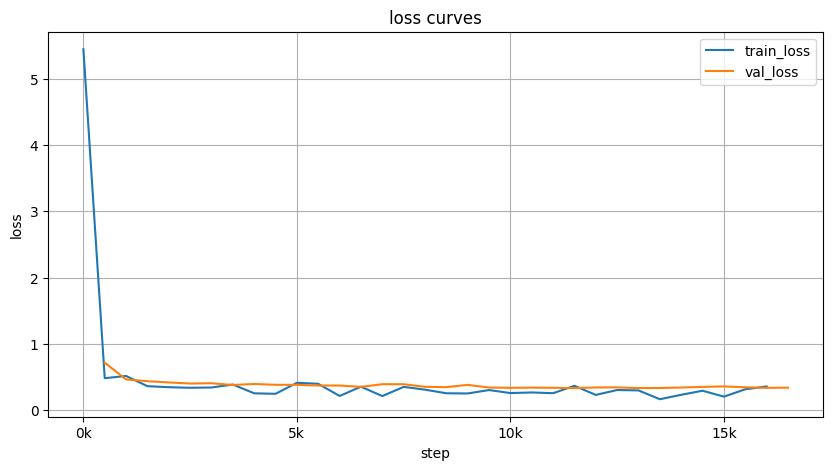

In [12]:
#画图
plot_learning_loss_curves(record_dict,sample_step=500)


In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
test_loss=evaluate_regression_model(model,test_loader,device,criterion)
print(f"测试集上的损失为{test_loss:.4f}")

测试集上的损失为0.3252
